In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from scipy import stats
import datetime

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import concatenate, Permute, Dense, Dropout, LSTM
from keras.constraints import maxnorm, nonneg

from attention import Attention

In [2]:
def window_mean(arr, num_steps, axis=1):
    assert num_steps < arr.shape[axis], f'num_steps ({num_steps}) must be a smaller than the length of the specified axis ({arr.shape[axis]})'
    assert arr.shape[axis] % num_steps == 0, f'num_steps must be a factor of the length of the specified axis ({arr.shape[axis]})'
    assert isinstance(num_steps, int), 'num_steps must be an integer'
    return np.array(np.split(arr, num_steps, axis=axis)).mean(axis=0).astype(np.float32)

def pull_apart(arr, lengths, axis=1):
    """Split array using the desired lengths. Lengths should add to the length of the array."""
    return np.split(arr, np.cumsum(lengths)[:-1], axis=axis)

daily_data = np.load('../data/dailyt30_features.npy', allow_pickle=True)
monthly_data = np.load('../data/monthly_features.npy', allow_pickle=True)
daily_target = np.load('../data/dailyt30_target.npy', allow_pickle=True)
monthly_target = np.load('../data/monthly_target.npy', allow_pickle=True)
month_range = pd.date_range(datetime.datetime(1979, 1, 1), datetime.datetime(2019, 1, 1), freq='M')

# Note that these must be factors of 30...
data = [
    daily_data,  # 1day
    window_mean(daily_data, 3),  # 3day
    window_mean(daily_data, 10),  # 10day
    window_mean(daily_data, 15),  # 15day
    monthly_data,  # 1mo (30day)
]

#Concatenate datasets and save lengths to pull them apart later
scales = [d.shape[1] for d in data]
data = np.concatenate(data, axis=1)

#Adding a lag to monthly targets
lag = 1
data = data[:-lag,:,:]
monthly_target = monthly_target[lag:]
month_range = month_range[lag:]

In [3]:
test_years = 7  # Num years to use in testing

LEN_DATA = len(data)
NUM_TRAIN = LEN_DATA - (12*test_years)
NUM_VALID = LEN_DATA - NUM_TRAIN

print(f'{LEN_DATA=}', f'i.e. {LEN_DATA / 12:.1f} years')
print(f'{NUM_TRAIN=}', f'i.e. {NUM_TRAIN / 12:.1f} years')
print(f'{NUM_VALID=}', f'i.e. {NUM_VALID / 12:.1f} years')

x_train = data[:NUM_TRAIN]
x_valid = data[NUM_TRAIN:]
y_train = monthly_target[:NUM_TRAIN]
y_valid = monthly_target[NUM_TRAIN:]
month_range_train = month_range[:NUM_TRAIN]
month_range_test = month_range[NUM_TRAIN:]

LEN_DATA=479 i.e. 39.9 years
NUM_TRAIN=395 i.e. 32.9 years
NUM_VALID=84 i.e. 7.0 years


In [4]:
def reshape_features(dataset, timesteps=1):
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    print(f'Converted from shape {dataset.shape} to shape {X.shape}')
    return X

timesteps = x_train.shape[1]

# Normalize the features, requires reshaping to 2D (?)
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[2]))
x_valid = scaler_f.transform(x_valid.reshape(-1,x_valid.shape[2]))

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1))
y_valid = scaler_l.transform(y_valid.reshape(-1,1))

# Revert it back to 3D
x_train = reshape_features(x_train, timesteps)
x_valid = reshape_features(x_valid, timesteps)

print(f'{x_train.shape=}')
print(f'{y_train.shape=}')
print(f'{x_valid.shape=}')
print(f'{y_valid.shape=}')

Converted from shape (18170, 11) to shape (395, 46, 11)
Converted from shape (3864, 11) to shape (84, 46, 11)
x_train.shape=(395, 46, 11)
y_train.shape=(395, 1)
x_valid.shape=(84, 46, 11)
y_valid.shape=(84, 1)


In [5]:
# Build ensemble model
num_features = 11

# Loop over each time scale (e.g. 1, 3, 10, 15, 30)
models = []
models_inputs = []
for num_days in scales:
    model_input= Input(shape=(num_days, num_features))
    
    model = Permute((2,1), input_shape=(num_days, num_features))(model_input)
    model = LSTM(64, return_sequences=True)(model)
    model = Dropout(0.2)(model)
    model = LSTM(32, return_sequences=True)(model)
    model = Attention()(model)
    model = Dense(1)(model)
    
    models_inputs.append(model_input)
    models.append(model)

ensemble = concatenate(models)
merged_model = Dense(1)(ensemble)
model = Model(inputs=models_inputs, outputs=merged_model, name='EALSTM')
model.summary()

Model: "EALSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 11)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 11)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 3, 11)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2, 11)]      0           []                               
                                                                                             

In [6]:
#Compiling the network
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

2022-02-20 18:38:59.083380: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-20 18:39:02.711409: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-02-20 18:39:02.711523: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM N

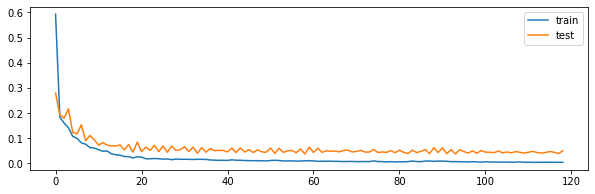

In [7]:
# Model x input is a list of arrays corresponding to each timeframe, so split the concatenated dataset into its parts
x_train_sets = pull_apart(x_train, scales, axis=1)
x_train_sets = [d.astype('float32') for d in x_train_sets]

x_valid_sets = pull_apart(x_valid, scales, axis=1)
x_valid_sets = [d.astype('float32') for d in x_valid_sets]

history=model.fit(
    x_train_sets,
    y_train,
    epochs=500,
    batch_size=64,
    verbose=0,
    validation_split=0.3,
    shuffle=True,
    callbacks=keras_callbacks)

plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [8]:
# Predict
pred_train = model.predict(x_train_sets)
pred_valid = model.predict(x_valid_sets)

# Inverse the transforms
pred_train_inv = scaler_l.inverse_transform(pred_train)
pred_valid_inv = scaler_l.inverse_transform(pred_valid)
y_valid_inv = scaler_l.inverse_transform(y_valid)
y_train_inv = scaler_l.inverse_transform(y_train)

2022-02-20 18:39:16.814133: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-02-20 18:39:16.814361: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memo

Test RMSE: 850014.6
Test NRMSE: 0.0789
Test R_Square: 0.937


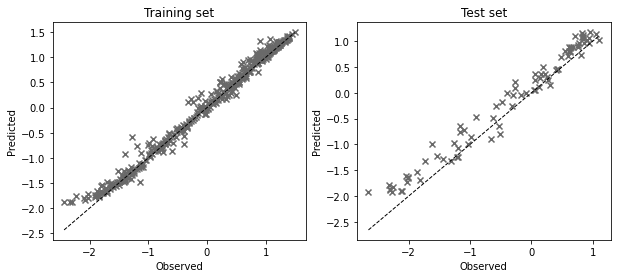

In [9]:
# RMSE
rmse = math.sqrt(mean_squared_error(y_valid_inv, pred_valid_inv))

# NRMSE
y_max = y_valid_inv.max()
y_min = y_valid_inv.min()
nrmse = rmse /(y_valid_inv.mean()) 

# R2
r_sq = r2_score(y_valid, pred_valid)

print(f'Test RMSE: {rmse:.1f}')
print(f'Test NRMSE: {nrmse:.4f}')
print(f'Test R_Square: {r_sq:.3f}')

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(y_train, pred_train, c='dimgrey', marker='x')
axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
axs[0].set_xlabel('Observed')
axs[0].set_ylabel('Predicted')
axs[0].set_title('Training set')

axs[1].scatter(y_valid, pred_valid, c='dimgrey', marker='x')
axs[1].plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=1)
axs[1].set_xlabel('Observed')
axs[1].set_ylabel('Predicted')
axs[1].set_title('Test set')

plt.show()

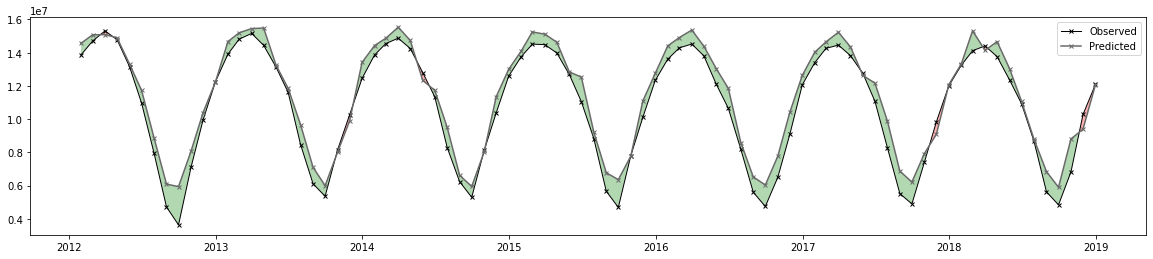

In [10]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(month_range_test, y_valid_inv, label='Observed', color='k', ls='-', lw=1, marker='x', markersize=4)
ax.plot(month_range_test, pred_valid_inv, label='Predicted', color='dimgrey', lw=1.5, marker='x', markersize=4)
ax.fill_between(month_range_test, y_valid_inv.flatten(), pred_valid_inv.flatten(), where=(pred_valid_inv<=y_valid_inv).flatten(), facecolor='red', alpha=0.3, interpolate=True)
ax.fill_between(month_range_test, y_valid_inv.flatten(), pred_valid_inv.flatten(), where=(pred_valid_inv>=y_valid_inv).flatten(), facecolor='green', alpha=0.3, interpolate=True)
plt.legend()
plt.show()

## Notes:
 * Consistent overprediction in testing set. May be climate change related? See below plot. Could incorporate offset to account for CC trend
 * Largest error in low SIE season. Likely largest variability in these months, but the overprediction is just more pronounced so may be way to correct
 * Ensembling is done by adding a dense layer at the end of the concatenated models. i.e. it uses a trained bias term and weights, so individual models are not necessarily each predicting SIE. Maybe better to have each model trained separately and use a (trained) weighted mean of these predictions. (Force bias=0 and weights>0 and sum to 1)
 * De-seasonalize! R2 score is worthless here, though MSE used for training is OK. De-seasonalizing might improve predictions. 
 * Spatial dimension may be added by introducing convolutions.
 * Could try seq to seq instead of single timestep prediction
 * Compare with same simpler algorithms as paper, but also a simple ARIMA / other autoregressive model
 * Could look at feature engineering, feature importance, PCA, etc. 

Trendline: -4816 km2 per month


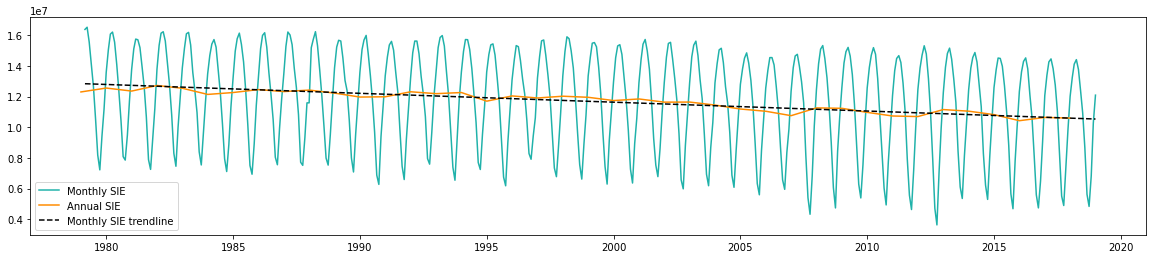

In [11]:
# Get annual averages
sie_df = pd.DataFrame({'SIE': monthly_target}, index=month_range)
sie_df_annual = sie_df.groupby(lambda x: datetime.datetime(x.year, 1, 1))['SIE'].agg('mean')

# Lin reg
linreg = stats.linregress(month_range.astype(int), list(monthly_target))
trendline = linreg.intercept + month_range.astype(int)*linreg.slope

plt.figure(figsize=(20, 4))
plt.plot(month_range, monthly_target, 'lightseagreen', label='Monthly SIE')
plt.plot(sie_df_annual.index, sie_df_annual, 'darkorange', label='Annual SIE')
plt.plot(month_range, trendline, 'k--', label='Monthly SIE trendline')
plt.legend()

print(f'Trendline: {np.mean(np.gradient(trendline)):.0f} km2 per month')

In [12]:
model_weights = model.layers[-1].weights[0].value().numpy()
print(f'Bias: {model.layers[-1].weights[1].value().numpy()[0]:.3f}')
for scale, weight in zip(scales, model_weights):
    print(f'{scale}-day model weight: {weight[0]:.3f}')

Bias: 0.006
30-day model weight: 0.808
10-day model weight: 0.274
3-day model weight: 0.448
2-day model weight: 0.491
1-day model weight: 0.048
